In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# importing all the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn import preprocessing
import urllib

In [3]:
# ignoring some warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [4]:
crashes = pd.read_csv('/content/drive/MyDrive/IADS Group Project/csv dumps/crashes-within-bikeroutes.csv')

In [5]:
crashes.head()

,Unnamed: 0,segmentid,geometry,index_right,crash_date,crash_time,on_street_name,number_of_cyclist_injured,number_of_cyclist_killed,vehicle_type_code1,vehicle_type_code2,borough,latitude,longitude,off_street_name
0,0,2579,POLYGON ((930013.2347051658 128748.06180844766...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5033,POLYGON ((939499.3061487563 153539.31437770283...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,10186,POLYGON ((949339.0524058095 170242.99560229736...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,20716,"POLYGON ((981425.563621944 174275.21570996908,...",109469.0,2024-02-23T00:00:00.000,2024-12-04 10:30:00,50 STREET,1.0,0.0,Station Wagon/Sport Utility Vehicle,Bike,BROOKLYN,40.645103,-74.01033,5 AVENUE
4,3,20716,"POLYGON ((981425.563621944 174275.21570996908,...",79444.0,2023-10-27T00:00:00.000,2024-12-04 17:31:00,50 STREET,0.0,0.0,Bike,NaN,BROOKLYN,40.645103,-74.01033,5 AVENUE


In [6]:
# loading the dataset
crashes = pd.read_csv('/content/drive/MyDrive/IADS Group Project/csv dumps/crashes-within-bikeroutes.csv')

# inspecting the dataset
print(crashes.info())
print(crashes.head())

# dropping irrelevant columns
crashes.drop(columns=['Unnamed: 0'], inplace=True)

# handling missing values
# dropping rows where essential columns are missing
essential_cols = ['crash_date', 'crash_time', 'borough', 'latitude', 'longitude']
crashes.dropna(subset=essential_cols, inplace=True)

# converting date and time columns
crashes['crash_date'] = pd.to_datetime(crashes['crash_date'], errors='coerce')
crashes['crash_time'] = pd.to_datetime(crashes['crash_time'], errors='coerce').dt.time

# converting injury and fatality columns to numeric
crashes['number_of_cyclist_injured'] = pd.to_numeric(crashes['number_of_cyclist_injured'], errors='coerce').fillna(0).astype(int)
crashes['number_of_cyclist_killed'] = pd.to_numeric(crashes['number_of_cyclist_killed'], errors='coerce').fillna(0).astype(int)

# summarizing data
print("Total Crashes:", len(crashes))
print("Total Cyclist Injuries:", crashes['number_of_cyclist_injured'].sum())
print("Total Cyclist Fatalities:", crashes['number_of_cyclist_killed'].sum())

# distributing crashes across boroughs
borough_counts = crashes['borough'].value_counts()
print("Crashes by Borough:")
print(borough_counts)

# frequency of crashes by time of day
crashes['hour'] = pd.to_datetime(crashes['crash_time'], format='%H:%M:%S', errors='coerce').dt.hour
hourly_crash_counts = crashes['hour'].value_counts().sort_index()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31346 entries, 0 to 31345
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 31346 non-null  int64  
 1   segmentid                  31346 non-null  int64  
 2   geometry                   31346 non-null  object 
 3   index_right                15260 non-null  float64
 4   crash_date                 15260 non-null  object 
 5   crash_time                 15260 non-null  object 
 6   on_street_name             13856 non-null  object 
 7   number_of_cyclist_injured  15260 non-null  float64
 8   number_of_cyclist_killed   15260 non-null  float64
 9   vehicle_type_code1         15260 non-null  object 
 10  vehicle_type_code2         12933 non-null  object 
 11  borough                    12294 non-null  object 
 12  latitude                   15260 non-null  float64
 13  longitude                  15260 non-null  flo

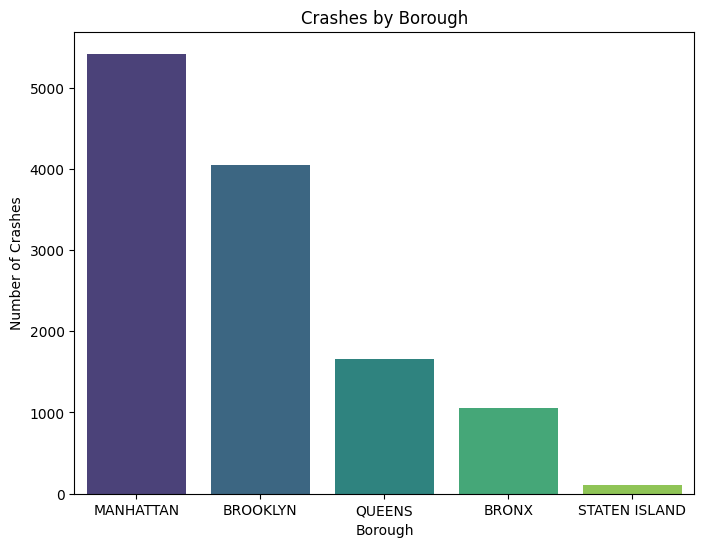

In [7]:
# plotting crashes by borough
plt.figure(figsize=(8, 6))
sns.barplot(x=borough_counts.index, y=borough_counts.values, palette='viridis')
plt.title('Crashes by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Crashes')
plt.show()

In [8]:
# frequency of crashes by time of day
crashes['hour'] = pd.to_datetime(crashes['crash_time'], format='%H:%M:%S', errors='coerce').dt.hour
hourly_crash_counts = crashes['hour'].value_counts().sort_index()

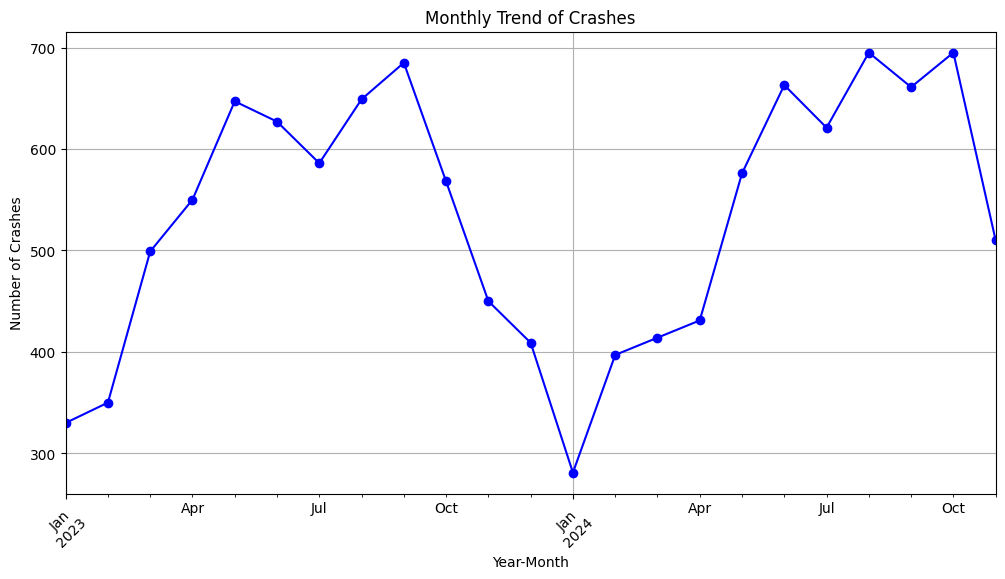

In [9]:
# temporal trend of crashes
crashes['year_month'] = crashes['crash_date'].dt.to_period('M')
monthly_trends = crashes['year_month'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
monthly_trends.plot(kind='line', marker='o', color='b')
plt.title('Monthly Trend of Crashes')
plt.xlabel('Year-Month')
plt.ylabel('Number of Crashes')
plt.xticks(rotation=45)
plt.grid()
plt.show()

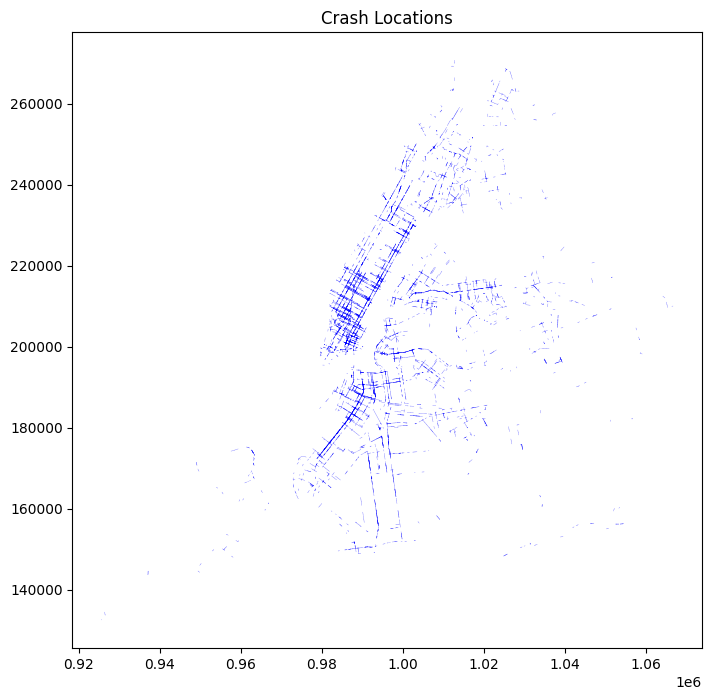

In [10]:
# geospatial visualization (optional)
if 'geometry' in crashes.columns:
    gdf = gpd.GeoDataFrame(crashes, geometry=gpd.GeoSeries.from_wkt(crashes['geometry']))
    gdf.plot(figsize=(10, 8), color='blue', alpha=0.5)
    plt.title('Crash Locations')
    plt.show()

In [11]:
bikelane = pd.read_csv('/content/drive/MyDrive/IADS Group Project/csv dumps/bike-lane-merge.csv')

In [12]:
bikelane.head()

,Unnamed: 0,bikedir,fromstreet,lanecount,facilitycl,ft2facilit,tf2facilit,tostreet,ret_date,bikeid,...,RW_TYPE,StreetWidth_Min,StreetWidth_Max,BikeLane,Snow_Priority,Number_Travel_Lanes,Number_Park_Lanes,BIKE_TRAFDIR,POSTED_SPEED,TRUCK_ROUTE_TYPE
0,0,2,HOLTEN AV,2,II,NaN,NaN,LUTEN AV,NaN,6562.0,...,1,70.0,70.0,2,C,4,,TW,40,2
1,3,2,RICHMOND HILL RD,2,II,NaN,NaN,ROCKLAND AV,NaN,4272.0,...,1,52.0,54.0,2,C,2,2,TW,25,
2,4,2,RICHMOND TERR,2,III,NaN,NaN,FOREST AVE,NaN,2107.0,...,1,30.0,32.0,3,C,2,1,TW,30,2
3,5,2,23 ST,2,III,NaN,NaN,50 ST,NaN,942.0,...,1,42.0,44.0,3,C,2,2,TW,25,
4,6,2,67 ST,2,III,NaN,NaN,FT HAMILTON PKWY,NaN,951.0,...,1,44.0,44.0,3,C,2,2,TW,25,


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# loading the dataset
bikelane = pd.read_csv('/content/drive/MyDrive/IADS Group Project/csv dumps/bike-lane-merge.csv')

# inspecting the dataset
print(bikelane.info())
print(bikelane.head())

# dropping irrelevant columns
bikelane.drop(columns=['Unnamed: 0'], inplace=True)

# handling missing values
# dropping rows with missing values in critical columns
critical_cols = ['bikedir', 'lanecount', 'facilitycl', 'StreetWidth_Min', 'POSTED_SPEED']
bikelane.dropna(subset=critical_cols, inplace=True)

# converting numeric columns to appropriate types
bikelane['lanecount'] = pd.to_numeric(bikelane['lanecount'], errors='coerce')
bikelane['StreetWidth_Min'] = pd.to_numeric(bikelane['StreetWidth_Min'], errors='coerce')
bikelane['POSTED_SPEED'] = pd.to_numeric(bikelane['POSTED_SPEED'], errors='coerce')

# summarizing data
print("Total Bike Lanes:", len(bikelane))
print("Unique Facility Types:", bikelane['facilitycl'].nunique())
print("Bike Lanes by Facility Type:")
print(bikelane['facilitycl'].value_counts())

# facility type distribution
facility_counts = bikelane['facilitycl'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27683 entries, 0 to 27682
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           27683 non-null  int64  
 1   bikedir              27683 non-null  object 
 2   fromstreet           27683 non-null  object 
 3   lanecount            27683 non-null  int64  
 4   facilitycl           27683 non-null  object 
 5   ft2facilit           52 non-null     object 
 6   tf2facilit           65 non-null     object 
 7   tostreet             27683 non-null  object 
 8   ret_date             4690 non-null   object 
 9   bikeid               27683 non-null  float64
 10  instdate             27683 non-null  object 
 11  tf_facilit           20762 non-null  object 
 12  shape_leng           27683 non-null  float64
 13  allclasses           27683 non-null  object 
 14  version              27683 non-null  object 
 15  onoffst              27683 non-null 

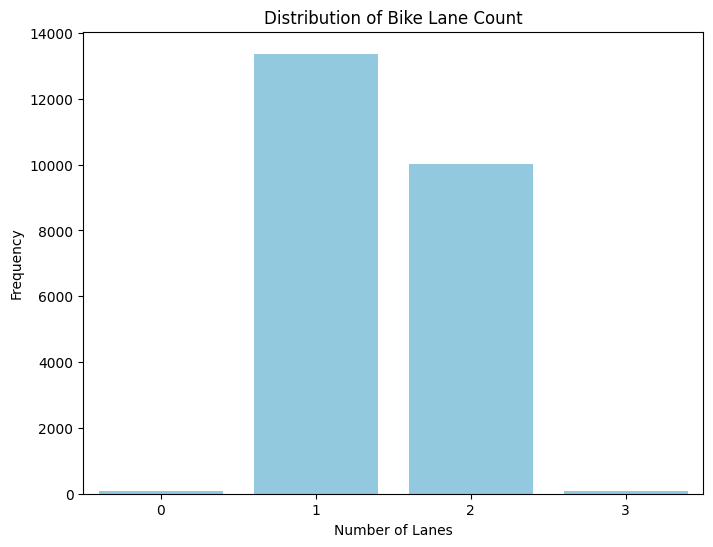

In [14]:
# counting occurrences of each lanecount value
lanecount_counts = bikelane['lanecount'].value_counts().sort_index()

# bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=lanecount_counts.index, y=lanecount_counts.values, color='skyblue')
plt.title('Distribution of Bike Lane Count')
plt.xlabel('Number of Lanes')
plt.ylabel('Frequency')
plt.xticks(lanecount_counts.index)
plt.show()

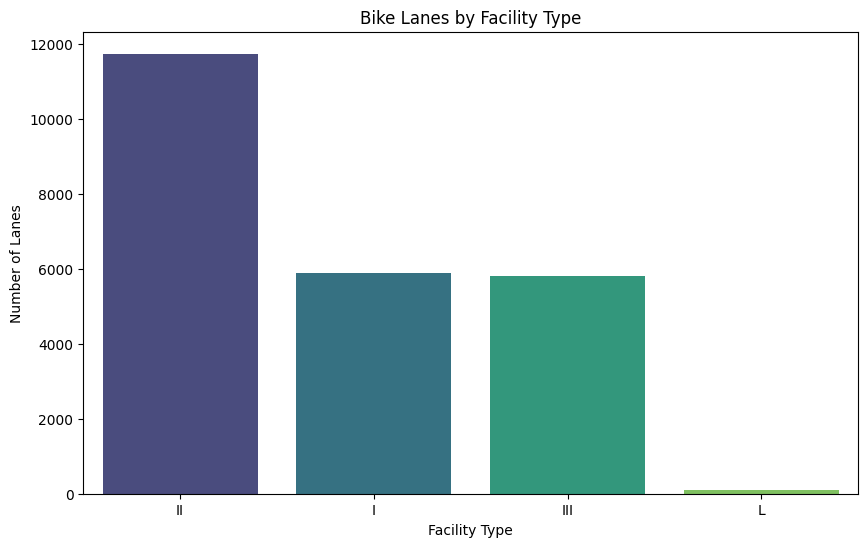

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(x=facility_counts.index, y=facility_counts.values, palette='viridis')
plt.title('Bike Lanes by Facility Type')
plt.xlabel('Facility Type')
plt.ylabel('Number of Lanes')
plt.show()

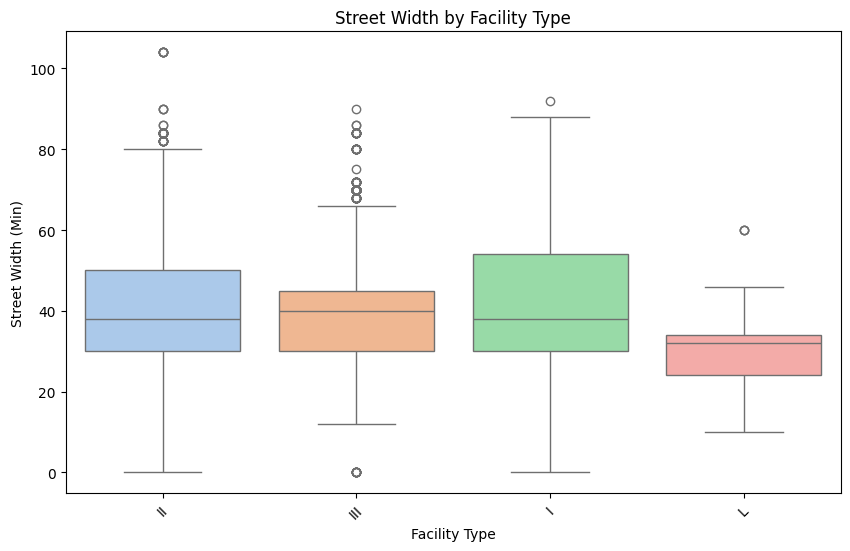

In [16]:
# street width analysis
plt.figure(figsize=(10, 6))
sns.boxplot(x='facilitycl', y='StreetWidth_Min', data=bikelane, palette='pastel')
plt.title('Street Width by Facility Type')
plt.xlabel('Facility Type')
plt.ylabel('Street Width (Min)')
plt.xticks(rotation=45)
plt.show()

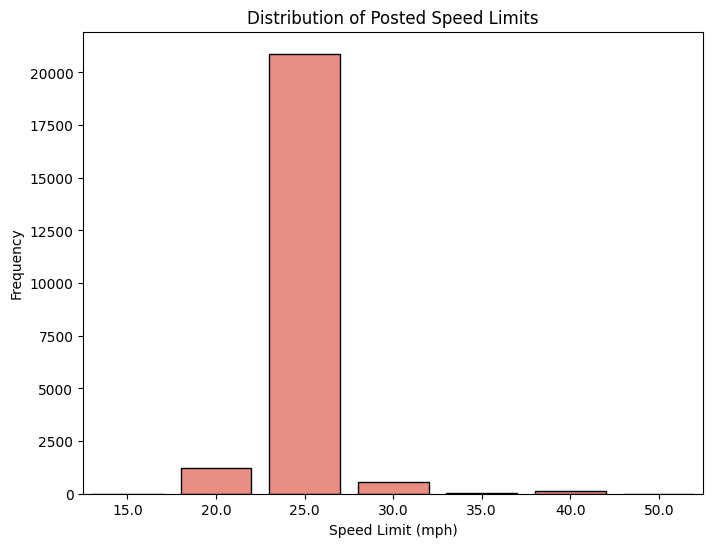

In [17]:
# count occurrences of each unique speed limit
speed_counts = bikelane['POSTED_SPEED'].value_counts().sort_index()

# bar plot for 'POSTED_SPEED'
plt.figure(figsize=(8, 6))
sns.barplot(x=speed_counts.index, y=speed_counts.values, color='salmon', edgecolor='black')
plt.title('Distribution of Posted Speed Limits')
plt.xlabel('Speed Limit (mph)')
plt.ylabel('Frequency')
plt.show()

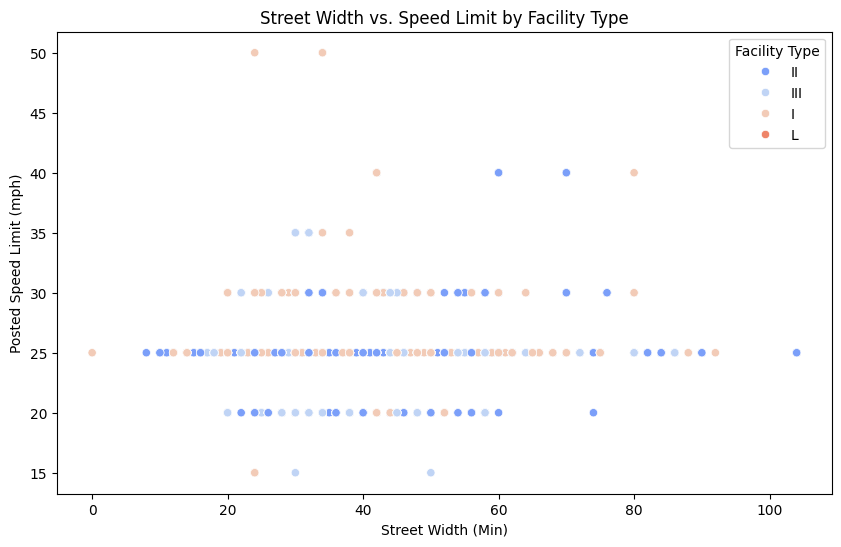

In [18]:
# relationship between street width and speed limit
plt.figure(figsize=(10, 6))
sns.scatterplot(x='StreetWidth_Min', y='POSTED_SPEED', hue='facilitycl', data=bikelane, palette='coolwarm')
plt.title('Street Width vs. Speed Limit by Facility Type')
plt.xlabel('Street Width (Min)')
plt.ylabel('Posted Speed Limit (mph)')
plt.legend(title='Facility Type', bbox_to_anchor=(1, 1))
plt.show()